In [38]:
# https://stackoverflow.com/questions/57422899/modulenotfounderror-no-module-named-jupyter-notebooks
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import warnings

import openpolicedata as opd

In [39]:
us_state_abbrev = {
    'AL' : 'Alabama', 
    'AK' : 'Alaska',
    'AS' : 'American Samoa',
    'AZ' : 'Arizona',
    'AR' : 'Arkansas',
    'CA' : 'California',
    'CO' : 'Colorado',
    'CT' : 'Connecticut',
    'DE' : 'Delaware',
    'DC' : 'District of Columbia',
    'FL' : 'Florida',
    'GA' : 'Georgia',
    'GU' : 'Guam',
    'HI' : 'Hawaii',
    'ID' : 'Idaho',
    'IL' : 'Illinois',
    'IN' : 'Indiana',
    'IA' : 'Iowa',
    'KS' : 'Kansas',
    'KY' : 'Kentucky',
    'LA' : 'Louisiana',
    'ME' : 'Maine',
    'MD' : 'Maryland',
    'MA' : 'Massachusetts',
    'MI' : 'Michigan',
    'MN' : 'Minnesota',
    'MS' : 'Mississippi',
    'MO' : 'Missouri',
    'MT' : 'Montana',
    'NE' : 'Nebraska',
    'NV' : 'Nevada',
    'NH' : 'New Hampshire',
    'NJ' : 'New Jersey',
    'NM' : 'New Mexico',
    'NY' : 'New York',
    'NC' : 'North Carolina',
    'ND' : 'North Dakota',
    'MP' : 'Northern Mariana Islands',
    'OH' : 'Ohio',
    'OK' : 'Oklahoma',
    'OR' : 'Oregon',
    'PA' : 'Pennsylvania',
    'PR' : 'Puerto Rico',
    'RI' : 'Rhode Island',
    'SC' : 'South Carolina',
    'SD' : 'South Dakota',
    'TN' : 'Tennessee',
    'TX' : 'Texas',
    'UT' : 'Utah',
    'VT' : 'Vermont',
    'VI' : 'Virgin Islands',
    'VA' : 'Virginia',
    'WA' : 'Washington',
    'WV' : 'West Virginia',
    'WI' : 'Wisconsin',
    'WY' : 'Wyoming'
}

def abbrev2state(state):
    if len(state) == 2: # Otherwise, assume state name was passed in
        state = us_state_abbrev[state.upper()]

    return state

def state2abbrev(state):
    if len(state) != 2:
        state = next(key for key, value in us_state_abbrev.items() if value == state)

    return state

state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [40]:
# Need to download https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip
state_file = "./notebooks/tl_2021_us_state.zip!tl_2021_us_state.shp"
state_df = gpd.read_file(state_file)
state_df = state_df.to_crs("EPSG:4326")

In [41]:
# Need to download from https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip
county_file = "./notebooks/tl_2021_us_county.zip!tl_2021_us_county.shp"
county_df = gpd.read_file(county_file)
county_df = county_df.to_crs("EPSG:4326")

(-127.7471505, -63.98726750000001, 23.14689945, 50.63388755)

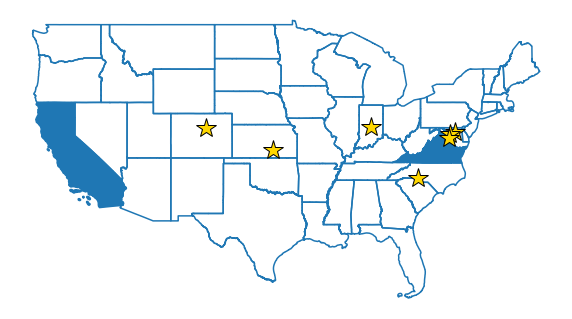

In [42]:
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us48 = state_df
for n in non_continental:
    us48 = us48[us48.STUSPS != n]

fig,ax = plt.subplots(figsize=(10,25))
us48.boundary.plot(ax=ax)
plotted = []
for i in range(len(opd.datasets)):
    abbrev = state2abbrev(opd.datasets.iloc[i]["State"])
    if opd.datasets.iloc[i]["SourceName"] in plotted:
        continue

    if "Police Department" not in opd.datasets.iloc[i]["SourceName"]:
        state = us48[us48.STUSPS == abbrev]
        state.plot(ax=ax)
        plotted.append(opd.datasets.iloc[i]["SourceName"])

for i in range(len(opd.datasets)):
    abbrev = state2abbrev(opd.datasets.iloc[i]["State"])
    if opd.datasets.iloc[i]["SourceName"] in plotted:
        continue
    plotted.append(opd.datasets.iloc[i]["SourceName"])
    if "Police Department" not in opd.datasets.iloc[i]["SourceName"]:
        pass
    elif "County" not in opd.datasets.iloc[i]["SourceName"]:
        city_name = opd.datasets.iloc[i]["SourceName"].replace("Police Department","").strip()
        city = cx.Place(f"{city_name}, {abbrev}")
        ax.plot(city.longitude, city.latitude, marker="*", markeredgecolor="k" ,markerfacecolor="gold", markersize=20)
    else:
        county_name = opd.datasets.iloc[i]["SourceName"].replace("Police Department","").strip()
        fips = state_codes[abbrev]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df = county_df[county_df["STATEFP"]==fips]
            df = df[county_df["NAMELSAD"]==county_name]
            a = df.centroid
        ax.plot(a.x, a.y, marker="*", markeredgecolor="k" ,markerfacecolor="gold", markersize=20)        

plt.axis('off')
